In [1]:
import time
import numpy as np
import pandas as pd
import argparse
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy import interpolate
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr
import scipy.sparse
import sys
import pickle
import re
from pyitlib import discrete_random_variable as drv
from dtit import dtit
from scipy import stats
from numpy import savetxt
from numpy import genfromtxt
import networkx as nx
from scipy.stats import norm
from entropy_estimators import *
import itertools
import math
import copy

In [28]:
def conditional_mutual_info(X,Y,Z=np.array(1)):
    
    if X.ndim == 1:
            X = np.reshape(X, (-1, 1))
    
    if Y.ndim == 1:
            Y = np.reshape(Y, (-1, 1))
            
    if Z.ndim == 0: 
        c1 = np.cov(X)
        
        if c1.ndim != 0: 
            d1 = np.linalg.det(c1)
        else:
            d1 = c1.item()
            
        c2 = np.cov(Y)
        
        if c2.ndim != 0: 
            d2 = np.linalg.det(c2)
        else:
            d2 = c2.item()
            
        c3 = np.cov(X,Y)
        
        if c3.ndim != 0: 
            d3 = np.linalg.det(c3)
        else:
            d3 = c3.item()
            
        cmi = (1/2)*np.log((d1*d2)/d3)
    
    else:
        
        if Z.ndim == 1:
            Z = np.reshape(Z, (-1, 1))
        
        c1 = np.cov(np.concatenate((X, Z), axis=0))
        
        if c1.ndim != 0: 
            d1 = np.linalg.det(c1)
        else:
            d1 = c1.item()
    
        c2 = np.cov(np.concatenate((Y, Z), axis=0))
        
        if c2.ndim != 0: 
            d2 = np.linalg.det(c2)
        else:
            d2 = c2.item()
            
        c3 = np.cov(Z)
        
        if c3.ndim != 0: 
            d3 = np.linalg.det(c3)
        else:
            d3 = c3.item()
            
        c4 = np.cov(np.concatenate((X, Y, Z), axis=0))
        
        if c4.ndim != 0: 
            d4 = np.linalg.det(c4)
        else:
            d4 = c4.item()
        
        cmi = (1/2)*np.log((d1*d2)/(d3*d4))
    
    
    if math.isinf(cmi):
        cmi = 0
    
    return cmi



In [79]:
def pca_cmi(data, theta, max_order):
    
    genes = list(data.columns)
    
    predicted_graph = nx.complete_graph(genes)
    num_edges = predicted_graph.number_of_edges()
    print("Number of edges in the initial complete graph : {}".format(num_edges))
    print()
    
    L = -1
    nochange = False
    
    while L < max_order and nochange == False:
        L = L+1
        predicted_graph, nochange = remove_edges(predicted_graph, data, L, theta)
        
        print("Order : {}".format(L))
        print("Number of edges in the predicted graph : {}".format(predicted_graph.number_of_edges()))
        print()
    
    
    print()
    print()
    print("Final Prediction:")
    print("-----------------")
    print("Order : {}".format(L))
    print("Number of edges in the predicted graph : {}".format(predicted_graph.number_of_edges()))
    nx.draw(predicted_graph, with_labels=True, font_weight='bold')
    print()
    return predicted_graph


def remove_edges(predicted_graph, data, L, theta):
    
    initial_num_edges = predicted_graph.number_of_edges()
    
    edges = predicted_graph.edges()

    for edge in edges:
        neighbors = nx.common_neighbors(predicted_graph, edge[0], edge[1])
        nhbrs = copy.deepcopy(sorted(neighbors))\
        
        T = len(nhbrs)
        
        if T < L and L != 0:
            continue
        
        else:
            x = data[edge[0]].to_numpy()
            if x.ndim == 1:
                x = np.reshape(x, (-1, 1))
            
            y = data[edge[1]].to_numpy()
            if y.ndim == 1:
                y = np.reshape(y, (-1, 1))
                
            K = list(itertools.combinations(nhbrs, L))
                
            if L == 0:
                cmiVal = conditional_mutual_info(x.T, y.T)
                
                if cmiVal < theta:
                    predicted_graph.remove_edge(edge[0], edge[1])
            
            else:  
                
                maxCmiVal = -999
                
                for zgroup in K:
                    
                    z = data[list(zgroup)].to_numpy()
                    if z.ndim == 1:
                        z = np.reshape(z, (-1, 1))
                    
                    cmiVal = conditional_mutual_info(x.T, y.T, z.T)
                    
                    if cmiVal > maxCmiVal:
                        maxCmiVal = cmiVal
                
                if maxCmiVal < theta:
                    predicted_graph.remove_edge(edge[0], edge[1])
                    
                
        
    final_num_edges = predicted_graph.number_of_edges()
        
    if final_num_edges < initial_num_edges:
        return  predicted_graph, False
        
        
    return  predicted_graph, True
            

In [80]:
data = pd.read_csv('Data/InSilicoSize10-Yeast1-trajectories.tsv', sep='\t')
data = data.drop(['Time'], axis=1)
data

,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10
0,0.827248,0.725743,0.389413,0.006674,0.156499,0.235751,0.673909,0.330327,0.740032,0.703382
1,0.654252,0.647066,0.508890,0.019373,0.408929,0.462383,0.584820,0.361024,0.796993,0.716660
2,0.544903,0.599011,0.555778,0.062856,0.322246,0.576507,0.566352,0.379408,0.688547,0.769349
3,0.587448,0.580601,0.556083,0.003298,0.311550,0.708266,0.595944,0.387101,0.772060,0.824500
4,0.578262,0.544896,0.687272,0.009736,0.469409,0.724303,0.572994,0.387153,0.856956,0.823019
...,...,...,...,...,...,...,...,...,...,...
79,0.386405,0.518757,0.845126,0.060462,0.525960,0.836324,0.449707,0.426285,0.801681,0.897166
80,0.566181,0.459482,0.814806,0.000000,0.499363,0.895484,0.446234,0.555992,0.920832,0.906946
81,0.454965,0.529461,0.897339,0.021698,0.539480,0.891079,0.408724,0.463280,0.908223,0.906211
82,0.477098,0.495149,0.842824,0.000000,0.581643,0.796469,0.438548,0.405291,0.780614,0.820773


Number of edges in the initial complete graph : 45

Order : 0
Number of edges in the predicted graph : 28

Order : 1
Number of edges in the predicted graph : 21

Order : 2
Number of edges in the predicted graph : 16

Order : 3
Number of edges in the predicted graph : 15

Order : 4
Number of edges in the predicted graph : 15



Final Prediction:
-----------------
Order : 4
Number of edges in the predicted graph : 15



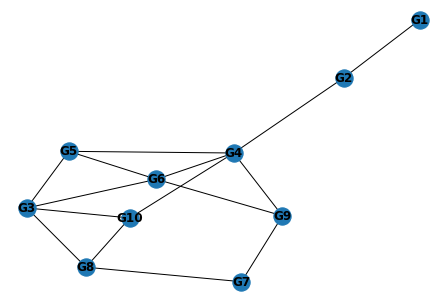

In [81]:
predicted_graph = pca_cmi(data, 0.03, 10)

In [82]:
benchmark_network = pd.read_csv('Test/DREAM3GoldStandard_InSilicoSize10_Yeast1.txt', sep='\t', header=None)
benchmark_network = benchmark_network.loc[benchmark_network[2] == 1]
benchmark_network

,0,1,2
0,G3,G1,1
1,G1,G2,1
2,G1,G4,1
3,G6,G4,1
4,G1,G5,1
5,G3,G5,1
6,G5,G7,1
7,G10,G7,1
8,G7,G8,1
9,G4,G9,1


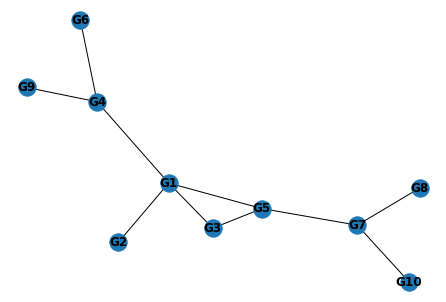

In [83]:
import matplotlib.pyplot as plt

benchmark_graph = nx.Graph()

for i in (1,10):
    benchmark_graph.add_node('G'+str(i))

for row in range(0,benchmark_network.shape[0]):
    benchmark_graph.add_edge(benchmark_network[0][row], benchmark_network[1][row])

nx.draw(benchmark_graph, with_labels=True, font_weight='bold')

In [84]:
editDistance = nx.graph_edit_distance(predicted_graph, benchmark_graph)
editDistance

7.0